In [1]:
import torch
import gc
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from torch import optim
import json
from PIL import Image
import io
import cv2
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import time
import os
import copy
import pickle
import urllib.request
import requests
from matplotlib.pyplot import imshow
import random
from utils import *

In [2]:
#Function to display image and predicted class
def imstats(name):
    # read in image and view it
    x = readim(name, forward_normalize) 
    imshow_tensor(x[0], inv_normalize)

    #get predicted class and probability
    prob = lay2(pretrained_model(x.cuda()))
    maxcls = prob.max(1)
    print("Class is {} ({}) with confidence {}%".format(maxcls.indices.item(),class_dict[maxcls.indices.item()],round(maxcls.values.item()*100,4)))

(225, 225)


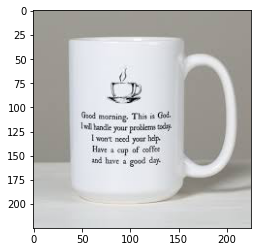

In [3]:
#Get classes
CLASS_URL = 'https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'
class_dict = pickle.load(urllib.request.urlopen(CLASS_URL))

#Retrieve image and assign class
#IMG_URL = "https://bloximages.chicago2.vip.townnews.com/chippewa.com/content/tncms/assets/v3/editorial/c/ca/cca0d87d-8d7c-520f-b012-bc065d18b3dd/553cbf5aa0ffb.image.jpg?crop=200%2C200%2C0%2C8&resize=1200%2C1200&order=crop%2Cresize"
#IMG_URL = "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSa3p29cIlgj0yQwMuLZzh8PKkgBUzbPLWrU-7K79DjDL498JsA&usqp=CAU"
IMG_URL = "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ5X7yUzT_3kR7guoqCF5zEFZkesvEkagag8Y1KFJoULsXrL3h0&usqp=CAU"
classidx = 504
response = requests.get(IMG_URL)
img = Image.open(io.BytesIO(response.content))
print(img.size)
imshow(img)

In [4]:
#Model parameters
model_img_size = 224
model_transform = transforms.Compose([transforms.Resize((model_img_size,model_img_size)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
forward_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

print(type(img))
img_input = model_transform(img)
#img_input = img_input.unsqueeze(0)
#img_input = Variable(img_input)
img_input.shape

<class 'PIL.JpegImagePlugin.JpegImageFile'>


torch.Size([3, 224, 224])

In [5]:
#Model definition
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_model = models.resnet101(pretrained=True)
pretrained_model.to(device)
pretrained_model.eval()

#Pass input through model
img_input = img_input.to(device)
pred = pretrained_model(img_input.unsqueeze(0))

#Use softmax to get predicted probability and view it
lay2 = torch.nn.Softmax(dim=1)
prob = lay2(pred)
maxOcls = prob.max(1)
print("Class is {} ({}) with confidence {}%".format(maxOcls.indices.item(),class_dict[maxOcls.indices.item()],maxOcls.values.item()*100))

Class is 504 (coffee mug) with confidence 85.15150547027588%


<class 'torch.Tensor'>


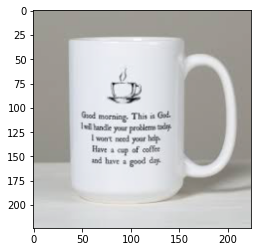

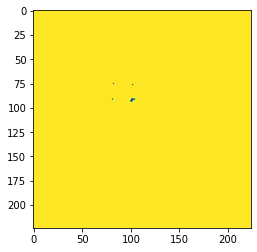

In [6]:
def get_object_mask(input_image):
    #print(test[-3][:])
    test = inv_normalize(input_image)
    test = np.uint8(test.numpy()*255).transpose((1,2,0))
    test = 1 - test
    #test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(test, cv2.COLOR_RGB2GRAY)
    th, thgray = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV); 
    #blurred = cv2.GaussianBlur(thgray, (9, 9), 0)
    th, blurred = cv2.threshold(thgray, 50, 255, cv2.THRESH_BINARY)
    edged = cv2.Canny(blurred, 1, 250, L2gradient=True)   
    #imgplot = plt.imshow(blurred, cmap="gray")
    #plt.show()
    return blurred
    #imshow(input_image[0])
    #applying closing function
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)    #finding_contours
    (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   
    #cnts = [] #only for plate class 
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        cv2.drawContours(closed, [approx], -1, (0, 255, 0), 2)    
    th, im_th = cv2.threshold(closed, 254, 255, cv2.THRESH_BINARY_INV);    
    h, w = im_th.shape[:2]
    im_floodfill = im_th.copy()
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 0);    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)    # Combine the two images to get the foreground.
    #imshow(im_th)
    #plt.show()
    #imshow(im_floodfill_inv)
    #plt.show()
    im_out = im_th ^ im_floodfill_inv
    im_out = cv2.GaussianBlur(im_out, (3, 3), 0)
    return im_out
print(type(img_input))
imshow_tensor(img_input.cpu(),inv_normalize)
imgplot = plt.imshow(get_object_mask(img_input.cpu()))
plt.show()

In [7]:
#Testing classes. Likely unnecessary
adv = [598, 697, 898, 567, 69, 855, 641, 600, 942]
fold = "c0.3_sz228_shiftF/"
#targidx = np.random.randint(0,1000)
targidx = adv[1]
print(targidx)

697


In [53]:


sz = 200   #Length of input signal
c = .5     #Ambient light ratio
c_limits = [0,0]
batch = 64
channels = 1
# change of variable term to optimise on
w = torch.rand([channels,sz,1], requires_grad=True, dtype=torch.float, device=device)

#Create the mask to only illuminate the object
mask = torch.tensor(get_object_mask(img_input.cpu()), dtype=torch.float, device=device)
mask = mask / torch.max(mask)


#Target and original class labels
target = torch.tensor([targidx], dtype=torch.long, device=device)
orig = torch.tensor([classidx], dtype=torch.long, device=device)

#Model parameters
lr = 1e-1
n_epochs = 5
optimizer = optim.SGD([w], lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [54]:
n_epochs = 5000
classes_to_skip = [classidx]#, 901, 968, 647,899]#,725,441,505,441,969,438,967]

 17%|█▋        | 833/5000 [07:43<38:42,  1.79it/s]

Switching from untarget to target 653


 18%|█▊        | 900/5000 [08:21<38:05,  1.79it/s]

tensor(7.6789, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.2063, device='cuda:0', grad_fn=<NllLossBackward>)


 20%|██        | 1000/5000 [09:16<37:09,  1.79it/s]

tensor(6.6385, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.0050, device='cuda:0', grad_fn=<NllLossBackward>)


 22%|██▏       | 1100/5000 [10:12<36:16,  1.79it/s]

tensor(6.0135, device='cuda:0', grad_fn=<NllLossBackward>) tensor(0.9617, device='cuda:0', grad_fn=<NllLossBackward>)


 24%|██▍       | 1200/5000 [11:08<35:14,  1.80it/s]

tensor(5.1960, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.1638, device='cuda:0', grad_fn=<NllLossBackward>)


 26%|██▌       | 1300/5000 [12:03<34:25,  1.79it/s]

tensor(4.9518, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.5849, device='cuda:0', grad_fn=<NllLossBackward>)


 28%|██▊       | 1400/5000 [12:59<33:23,  1.80it/s]

tensor(4.4875, device='cuda:0', grad_fn=<NllLossBackward>) tensor(1.9717, device='cuda:0', grad_fn=<NllLossBackward>)


 30%|███       | 1500/5000 [13:55<32:33,  1.79it/s]

tensor(4.3145, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.1188, device='cuda:0', grad_fn=<NllLossBackward>)


 32%|███▏      | 1600/5000 [14:50<31:38,  1.79it/s]

tensor(4.4648, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.3012, device='cuda:0', grad_fn=<NllLossBackward>)


 34%|███▍      | 1700/5000 [15:46<30:36,  1.80it/s]

tensor(4.4848, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.1439, device='cuda:0', grad_fn=<NllLossBackward>)


 36%|███▌      | 1800/5000 [16:42<29:34,  1.80it/s]

tensor(4.0128, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.4090, device='cuda:0', grad_fn=<NllLossBackward>)


 38%|███▊      | 1900/5000 [17:38<28:53,  1.79it/s]

tensor(3.9996, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.4969, device='cuda:0', grad_fn=<NllLossBackward>)


 40%|████      | 2000/5000 [18:33<27:50,  1.80it/s]

tensor(3.9375, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.4957, device='cuda:0', grad_fn=<NllLossBackward>)


 42%|████▏     | 2100/5000 [19:29<27:00,  1.79it/s]

tensor(3.7763, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.4615, device='cuda:0', grad_fn=<NllLossBackward>)


 44%|████▍     | 2200/5000 [20:25<25:47,  1.81it/s]

tensor(3.8965, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.4759, device='cuda:0', grad_fn=<NllLossBackward>)


 46%|████▌     | 2300/5000 [21:20<25:00,  1.80it/s]

tensor(4.1826, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.6064, device='cuda:0', grad_fn=<NllLossBackward>)


 48%|████▊     | 2400/5000 [22:16<24:12,  1.79it/s]

tensor(3.9202, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.5305, device='cuda:0', grad_fn=<NllLossBackward>)


 50%|█████     | 2500/5000 [23:12<23:16,  1.79it/s]

tensor(3.7449, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.8021, device='cuda:0', grad_fn=<NllLossBackward>)


 52%|█████▏    | 2600/5000 [24:08<22:14,  1.80it/s]

tensor(3.7341, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.9633, device='cuda:0', grad_fn=<NllLossBackward>)


 54%|█████▍    | 2700/5000 [25:04<21:25,  1.79it/s]

tensor(3.7499, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.8309, device='cuda:0', grad_fn=<NllLossBackward>)


 56%|█████▌    | 2800/5000 [26:00<20:25,  1.80it/s]

tensor(3.7475, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.6651, device='cuda:0', grad_fn=<NllLossBackward>)


 58%|█████▊    | 2900/5000 [26:55<19:33,  1.79it/s]

tensor(3.7994, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.7621, device='cuda:0', grad_fn=<NllLossBackward>)


 60%|██████    | 3000/5000 [27:51<18:35,  1.79it/s]

tensor(3.9287, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.7205, device='cuda:0', grad_fn=<NllLossBackward>)


 62%|██████▏   | 3100/5000 [28:47<17:41,  1.79it/s]

tensor(3.5700, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.5800, device='cuda:0', grad_fn=<NllLossBackward>)


 64%|██████▍   | 3200/5000 [29:43<16:49,  1.78it/s]

tensor(3.7783, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.7972, device='cuda:0', grad_fn=<NllLossBackward>)


 66%|██████▌   | 3300/5000 [30:39<15:48,  1.79it/s]

tensor(3.8562, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.8514, device='cuda:0', grad_fn=<NllLossBackward>)


 68%|██████▊   | 3400/5000 [31:35<14:48,  1.80it/s]

tensor(3.7453, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.9169, device='cuda:0', grad_fn=<NllLossBackward>)


 70%|███████   | 3500/5000 [32:31<13:56,  1.79it/s]

tensor(3.6322, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.6582, device='cuda:0', grad_fn=<NllLossBackward>)


 72%|███████▏  | 3600/5000 [33:27<13:02,  1.79it/s]

tensor(3.5963, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.7148, device='cuda:0', grad_fn=<NllLossBackward>)


 74%|███████▍  | 3700/5000 [34:22<12:06,  1.79it/s]

tensor(3.4989, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.6369, device='cuda:0', grad_fn=<NllLossBackward>)


 76%|███████▌  | 3800/5000 [35:18<11:09,  1.79it/s]

tensor(3.4140, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.7534, device='cuda:0', grad_fn=<NllLossBackward>)


 78%|███████▊  | 3900/5000 [36:14<10:13,  1.79it/s]

tensor(3.4766, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.7203, device='cuda:0', grad_fn=<NllLossBackward>)


 80%|████████  | 4000/5000 [37:10<09:19,  1.79it/s]

tensor(3.4874, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.6490, device='cuda:0', grad_fn=<NllLossBackward>)


 82%|████████▏ | 4100/5000 [38:06<08:21,  1.79it/s]

tensor(3.3900, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.7353, device='cuda:0', grad_fn=<NllLossBackward>)


 84%|████████▍ | 4200/5000 [39:02<07:24,  1.80it/s]

tensor(3.4010, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.5680, device='cuda:0', grad_fn=<NllLossBackward>)


 86%|████████▌ | 4300/5000 [39:57<06:30,  1.79it/s]

tensor(3.4942, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.4848, device='cuda:0', grad_fn=<NllLossBackward>)


 88%|████████▊ | 4400/5000 [40:53<05:37,  1.78it/s]

tensor(3.4565, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.7762, device='cuda:0', grad_fn=<NllLossBackward>)


 90%|█████████ | 4500/5000 [41:49<04:39,  1.79it/s]

tensor(3.5249, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.9947, device='cuda:0', grad_fn=<NllLossBackward>)


 92%|█████████▏| 4600/5000 [42:45<03:42,  1.80it/s]

tensor(3.5402, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.6970, device='cuda:0', grad_fn=<NllLossBackward>)


 94%|█████████▍| 4700/5000 [43:40<02:47,  1.79it/s]

tensor(3.3789, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.4960, device='cuda:0', grad_fn=<NllLossBackward>)


 96%|█████████▌| 4800/5000 [44:36<01:51,  1.79it/s]

tensor(3.2424, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.6478, device='cuda:0', grad_fn=<NllLossBackward>)


 98%|█████████▊| 4900/5000 [45:32<00:55,  1.79it/s]

tensor(3.4245, device='cuda:0', grad_fn=<NllLossBackward>) tensor(2.6625, device='cuda:0', grad_fn=<NllLossBackward>)


100%|██████████| 5000/5000 [46:28<00:00,  1.79it/s]


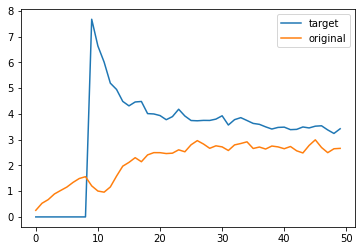

In [55]:
#Track the loss to target and original class
targloss = []
origloss = []

#obj_dict = {}

#Optimisation loop. initially untargeted
for epoch in tqdm(range(n_epochs)):
    
    #Switch to targeted at halfway point
    half = epoch < n_epochs//6
    if epoch == n_epochs//6:
        tops = out.topk(20).indices[0]
        for t in tops:
            #print(t.item())
            if t.item() not in classes_to_skip: 
                targidx = t.item()
        #targidx = tops[0].item() if tops[0].item() != classidx else tops[1].item()
        target = torch.tensor([targidx], dtype=torch.long, device=device)
        print("Switching from untarget to target {}".format(targidx))
    
    if channels==1:
        n_w = w.repeat(3,1,1)
    else:
        n_w = w
    gy, new_w = fttogy(n_w, batch, mask, c_limits, 263)
    
    inp = gy*inv_normalize(img_input)   
    inp = torch.cat([forward_normalize(i).unsqueeze(0) for i in inp])
    out = pretrained_model(inp)

    #Calculate Loss depended on if targeted or untargeted
    if not half: targLoss = loss_fn(out, target.repeat(batch))
    origLoss = loss_fn(out, orig.repeat(batch))
    loss = -origLoss if half else targLoss
    if epoch%100 == 0:
        targloss.append(0 if half else targLoss)
        origloss.append(origLoss)
        if not half: print(targLoss, origLoss) 
    loss.backward()   
    
    optimizer.step()
    
    optimizer.zero_grad()
    
    del loss
    if epoch!=n_epochs-1:
        del inp
        del new_w
    #else:
        #saving w to be used for prediction
        #torch.save(n_w,'w_0.5_764.pt')

    #Code to check gpu allocation    
    '''
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                #print(type(obj), obj.size())
                if type(obj) not in obj_dict:
                    obj_dict[type(obj)] = 1
                else:
                    obj_dict[type(obj)] += 1
        except: pass
    print(obj_dict)
    obj_dict.clear()
    '''
    torch.cuda.empty_cache()
#View original loss and target loss
plt.plot(targloss, label="target")
plt.plot(origloss, label="original")
plt.legend()
plt.show()

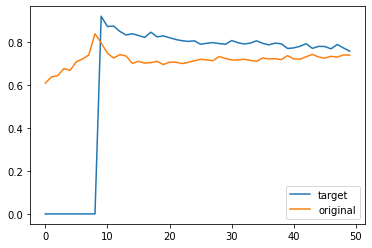

In [59]:
#View original loss and target loss
plt.plot(targloss, label="target")
plt.plot(origloss, label="original")
plt.legend()
plt.show()

In [59]:
#Create softmax layer to view probabilities
lay2 = torch.nn.Softmax(dim=1)
prob = lay2(out)
maxcls = prob.max(1)
#print(maxcls)
for i in range(batch):
    #print("alpha: {}".format(c[i].item()))
    print("target {}: {}%".format(targidx,prob[i][targidx]))
    print("Orig {}: {}%".format(classidx,prob[i][classidx]))
    print("Class is {} ({}) with confidence {}%\n".format(maxcls.indices[i].item(),class_dict[maxcls.indices[i].item()],maxcls.values[i].item()*100))

target 653: 0.0479414276778698%
Orig 504: 0.09708700329065323%
Class is 647 (measuring cup) with confidence 23.44835102558136%

target 653: 0.018940366804599762%
Orig 504: 0.2954930365085602%
Class is 968 (cup) with confidence 35.81158220767975%

target 653: 0.11059047281742096%
Orig 504: 0.22612431645393372%
Class is 504 (coffee mug) with confidence 22.61243164539337%

target 653: 0.027284661307930946%
Orig 504: 0.01771240495145321%
Class is 713 (photocopier) with confidence 26.03251039981842%

target 653: 0.029593804851174355%
Orig 504: 0.03484503924846649%
Class is 647 (measuring cup) with confidence 39.96374011039734%

target 653: 0.052788667380809784%
Orig 504: 0.04667464271187782%
Class is 647 (measuring cup) with confidence 12.452756613492966%

target 653: 0.05117147043347359%
Orig 504: 0.1422814428806305%
Class is 504 (coffee mug) with confidence 14.22814428806305%

target 653: 0.022403495386242867%
Orig 504: 0.08874153345823288%
Class is 647 (measuring cup) with confidence 25.

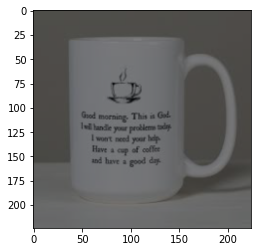

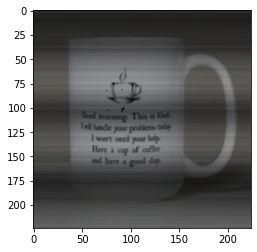

In [58]:
#View input image and adversarial image. Save both
imshow_tensor(forward_normalize(inv_normalize(img_input.cpu())*c), inv_normalize)
imshow_tensor(inp[2].detach().cpu(),inv_normalize)
#saveim(img_input.cpu(), "original_{}.png".format(classidx),inv_normalize)
#saveim(forward_normalize(inv_normalize(img_input.cpu())*c), "original_c{}_{}.png".format(c,classidx),inv_normalize)
#saveim(inp, "src{}_c{}_sz{}_tg{}.png".format(classidx,c,sz,targidx),inv_normalize)

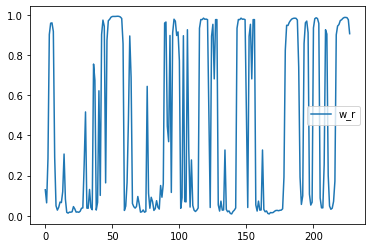

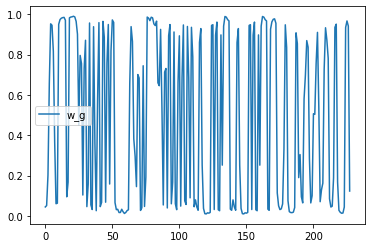

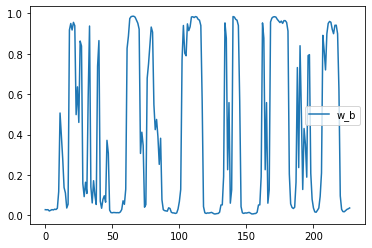

In [36]:
plt.plot(torch.flatten(new_w[0][0]).detach().cpu(), label="w_r")
plt.legend()
plt.show()
plt.plot(torch.flatten(new_w[0][1]).detach().cpu(), label="w_g")
plt.legend()
plt.show()
plt.plot(torch.flatten(new_w[0][2]).detach().cpu(), label="w_b")
plt.legend()
plt.show()

In [ ]:
#View the attack signal colour channels separately
test = torch.ones([3,224,224], device=device)
re = test * split(gy_mask,0)
gr = test * split(gy_mask,1)
bl = test * split(gy_mask,2)
imshow_tensor(forward_normalize(re.detach().cpu()), inv_normalize)
imshow_tensor(forward_normalize(gr.detach().cpu()), inv_normalize)
imshow_tensor(forward_normalize(bl.detach().cpu()), inv_normalize)

In [ ]:
imstats("original_919.png")
imstats("original_c0.5_919.png")
imstats("original_c0.3_919.png")